In [0]:
#from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, GaussianNoise
from keras import regularizers
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import pandas as pd
import random
import os
import shutil
import matplotlib.pyplot as plt


**Loading the dataset**

In [38]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Augmentation**

In [39]:
TRAIN_DIR = "drive/My Drive/Dataset/Food_images/Train"
VALIDATION_DIR = "drive/My Drive/Dataset/Food_images/Validation/"
TEST_DIR = "/drive/My Drive/Dataset/Food_images/test/"
HEIGHT = 299
WIDTH = 299
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)



train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                   target_size=(HEIGHT, WIDTH),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   color_mode='rgb')



Found 6586 images belonging to 25 classes.


In [40]:
#Need to construct a validation set for the set
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)


validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'
)

Found 743 images belonging to 25 classes.


**Display the Augmented images**

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


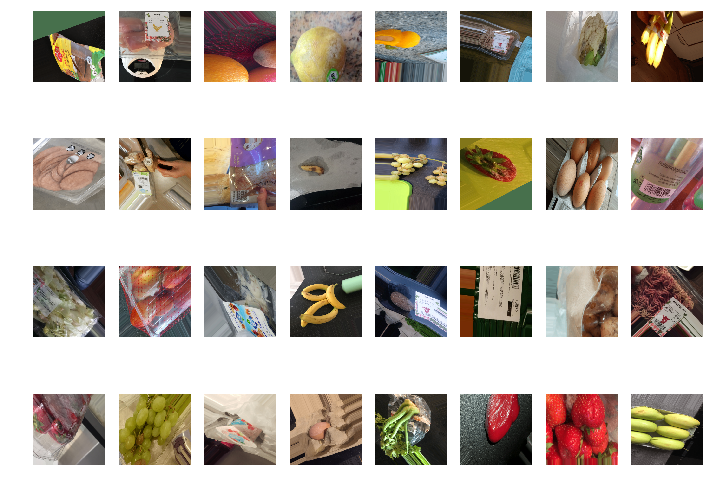

In [41]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


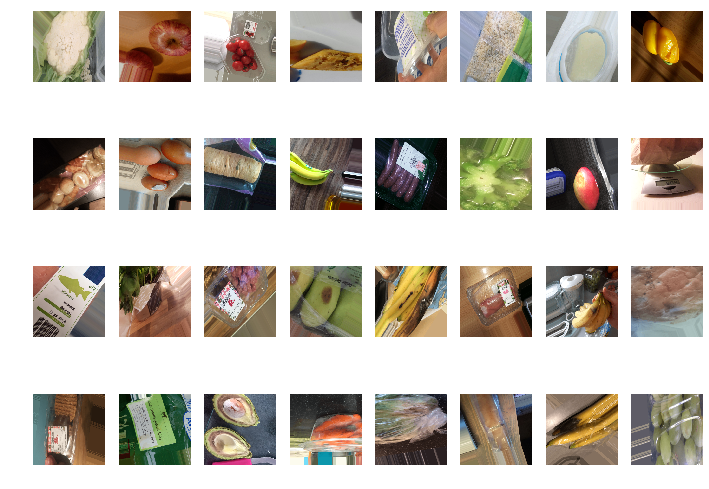

In [42]:
x_batch, y_batch = next(validation_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [0]:
#name of the target classes
class_list = ['Bananas, apples & pears', 'Berries & cherries',
       'Pork, beef & lamb', 'Bell peppers, zucchinis & eggplants',
       'Pudding, yogurt & quark', 'Minced meat & meatballs', 'Eggs',
       'Cucumber, tomatoes & avocados', 'Citrus fruits', 'Fish',
       'Onions, leek, garlic & beets', 'Kiwis, grapes & mango',
       'Fresh bread', 'Cheese', 'Salad & cress', 'Pre-baked breads',
       'Fresh herbs', 'Nectarines, peaches & apricots',
       'Lunch & Deli Meats', 'Milk', 'Potatoes',
       'Broccoli, cauliflowers, carrots & radish',
       'Asparagus, string beans & brussels sprouts', 'Poultry',
       'Pineapples, melons & passion fruit']
len(class_list)

## create mapping from for prediction score
classes = train_generator.class_indices 
class_map = {value:key for key,value in classes.items()}
#print (class_map)

**Loading the pre-trained model**

In [0]:
# load the pre-trained model
base_model = InceptionV3(weights='imagenet', 
                         include_top=False, 
                         input_shape=(HEIGHT,WIDTH,3))

In [0]:
#Fine-tuning the pretrained model using the dataset
def build_finetune_model(base_model, dropout,fc_layers, num_classes, fine_tune_at):
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
        
    x = base_model.output
    #x = Flatten()(x)
    x = GlobalAveragePooling2D(name='max_pool')(x)
    x = GaussianNoise(0.1)(x)
    
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc,activation='relu')(x)
        x = Dropout(dropout)(x)
    
    x = Dense(64, input_dim=64,kernel_regularizer=regularizers.l2(0.01))(x)
    # New Softmax layer
    prediction = Dense(num_classes, activation='softmax')(x)
    
    finetune_model = Model(input=base_model.input, output=prediction)
    
    return finetune_model

In [55]:
FC_LAYERS = [1024,1024]
dropout = 0.6
print (len(base_model.layers))

311


In [56]:
finetune_model = build_finetune_model(base_model,
                                     dropout=dropout,
                                     fc_layers=FC_LAYERS,
                                     num_classes=len(class_list),
                                     fine_tune_at=40)

#print (finetune_model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


**Training the model**

In [0]:
# hyperparameter of the model
NUM_EPOCHS = 100
BATCH_SIZE = 32
num_train_images = len(train_generator.index_array)
num_validation_images = len(validation_generator.index_array)

In [0]:
MODEL_NAME = "InceptionV3_adam"

In [0]:
MODEL_FILE = 'drive/My Drive/Dataset/' + MODEL_NAME + '.model'

#optimizier for the network
adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', 
                       metrics=['accuracy'])

#print (finetune_model.summary())

In [0]:
filepath="drive/My Drive/Dataset/" + MODEL_NAME + "_model_weights.h5"

checkpoint = [EarlyStopping(monitor='val_acc', patience=5, verbose=2),ModelCheckpoint(filepath, monitor="val_acc", verbose=1, mode='auto', save_best_only=True)]
callbacks_list = checkpoint

history = finetune_model.fit_generator(train_generator, 
                                       epochs=NUM_EPOCHS, 
                                       workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, 
                                       callbacks=callbacks_list,
                                       validation_data=validation_generator,
                                       validation_steps=num_validation_images // BATCH_SIZE)



Epoch 1/100


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 39/205 [====>.........................] - ETA: 5:47 - loss: 4.8663 - acc: 0.0329

In [0]:
finetune_model.save(filepath)

**Model Evaluation**

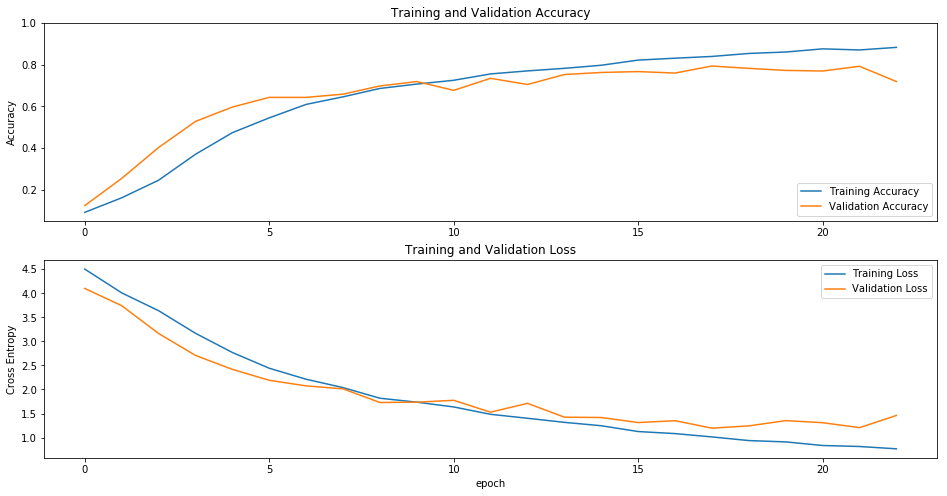

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

****Prediction using the above trained model****

In [0]:
## create mapping from for prediction score
classes = train_generator.class_indices 
class_map = {value:key for key,value in classes.items()}
print (class_map)

In [0]:
def predict_model(image_path):
  img = image.load_img(image_path, target_size=(WIDTH, HEIGHT))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  images = np.vstack([x])
  y_prob = finetune_model.predict(images)
  y_classes = y_prob.argmax(axis=-1)
  print (class_map.get(y_classes[0]))
  return class_map.get(y_classes[0])

In [33]:
mypath = os.getcwd() + TEST_DIR
test_filenames = os.listdir(mypath)
print (len(test_filenames))
print(test_filenames)


#Prediction
result_dict = {}
for filename in test_filenames:
  image_path = "drive/My Drive/Dataset/Food_images/test/" + filename
  print(image_path)
  result_dict[filename] = predict_model(image_path)

820
['7263.jpeg', '7265.jpeg', '7271.png', '7264.jpeg', '7273.jpeg', '7272.jpeg', '7267.jpeg', '7268.png', '7266.png', '7270.png', '7274.png', '7269.jpeg', '7275.png', '7313.jpeg', '7283.jpeg', '7282.jpeg', '7278.jpeg', '7280.png', '7276.jpeg', '7279.png', '7281.jpeg', '7277.png', '7284.png', '7347.jpeg', '7285.jpeg', '7288.png', '7289.png', '7293.png', '7294.png', '7286.jpeg', '7290.png', '7291.jpeg', '7287.jpeg', '7292.png', '7371.jpeg', '7396.jpeg', '7295.png', '7435.jpeg', '7300.jpeg', '7304.png', '7297.png', '7299.jpeg', '7302.png', '7296.jpeg', '7298.png', '7303.jpeg', '7301.png', '7462.jpeg', '7510.jpeg', '7305.jpeg', '7307.png', '7311.png', '7306.png', '7308.jpeg', '7309.jpeg', '7310.png', '7516.jpeg', '7314.png', '7312.jpeg', '7315.png', '7529.jpeg', '7316.png', '7540.jpeg', '7321.png', '7320.jpeg', '7325.jpeg', '7323.png', '7319.png', '7324.jpeg', '7322.jpeg', '7318.png', '7317.png', '7567.jpeg', '7326.jpeg', '7335.jpeg', '7330.png', '7327.jpeg', '7334.jpeg', '7587.jpeg', '73

NameError: ignored

**Prediction using the ensemble method onthe test set**

In [0]:
model_IncRes = load_model("drive/My Drive/Dataset/InceptionResNetV2_finetune40_maxpool_model_weights.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
model_Xcep = load_model("drive/My Drive/Dataset/XceptionV3_finetune60_model_weights.h5")

In [0]:
model_IncV3 = load_model("drive/My Drive/Dataset/InceptionV3_finetune60_model_weights.h5")

In [0]:
model_IncResE150 = load_model("drive/My Drive/Dataset/InceptionResNetV2_epoch5_fine_tune_at100_epoch150_model_weights.h5")

In [0]:
models = [model_Xcep, model_IncV3, model_IncResE150]

In [0]:
def ensemble_predictions(models_members, image_path):
  #print (image_path)
  img = image.load_img(image_path, target_size=(WIDTH, HEIGHT))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  images = np.vstack([x])
  
	# make predictions
  ensemble_pred = [model.predict(images) for model in models_members]
  #print (ensemble_pred)
  #print ("heasdsa")
  # sum across ensemble members
  summed = np.mean(ensemble_pred, axis=0)
  
  #print ("Mean value of the predication: ", summed)

  #idx = (-summed[0]).argsort()[:5]
  #print (idx)
  #print ('Top 3 Result')
  #for i in idx:
    #print (class_map.get(i))

  #print ("Top result")
  # argmax across classes
  result = np.argmax(summed, axis=1)
  print (class_map.get(result[0]))
  return class_map.get(result[0])

In [0]:
# Ensemble Prediction
mypath = os.getcwd() + TEST_DIR
test_filenames = os.listdir(mypath)
print (len(test_filenames))
print(test_filenames)


#Prediction
result_dict = {}
for filename in test_filenames:
  image_path = "drive/My Drive/Dataset/Food_images/test/" + filename
  #print (image_path)
  #predict_model(image_path)
  print(image_path)
  result_dict[filename] = ensemble_predictions(models, image_path)

820
['7263.jpeg', '7265.jpeg', '7271.png', '7264.jpeg', '7273.jpeg', '7272.jpeg', '7267.jpeg', '7268.png', '7266.png', '7270.png', '7274.png', '7269.jpeg', '7275.png', '7313.jpeg', '7283.jpeg', '7282.jpeg', '7278.jpeg', '7280.png', '7276.jpeg', '7279.png', '7281.jpeg', '7277.png', '7284.png', '7347.jpeg', '7285.jpeg', '7288.png', '7289.png', '7293.png', '7294.png', '7286.jpeg', '7290.png', '7291.jpeg', '7287.jpeg', '7292.png', '7371.jpeg', '7396.jpeg', '7295.png', '7435.jpeg', '7300.jpeg', '7304.png', '7297.png', '7299.jpeg', '7302.png', '7296.jpeg', '7298.png', '7303.jpeg', '7301.png', '7462.jpeg', '7510.jpeg', '7305.jpeg', '7307.png', '7311.png', '7306.png', '7308.jpeg', '7309.jpeg', '7310.png', '7516.jpeg', '7314.png', '7312.jpeg', '7315.png', '7529.jpeg', '7316.png', '7540.jpeg', '7321.png', '7320.jpeg', '7325.jpeg', '7323.png', '7319.png', '7324.jpeg', '7322.jpeg', '7318.png', '7317.png', '7567.jpeg', '7326.jpeg', '7335.jpeg', '7330.png', '7327.jpeg', '7334.jpeg', '7587.jpeg', '73

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Kiwis, grapes & mango
drive/My Drive/Dataset/Food_images/test/7283.jpeg
Pork, beef & lamb
drive/My Drive/Dataset/Food_images/test/7282.jpeg
Cucumber, tomatoes & avocados
drive/My Drive/Dataset/Food_images/test/7278.jpeg
Lunch & Deli Meats
drive/My Drive/Dataset/Food_images/test/7280.png
Salad & cress
drive/My Drive/Dataset/Food_images/test/7276.jpeg
Berries & cherries
drive/My Drive/Dataset/Food_images/test/7279.png
Bananas, apples & pears
drive/My Drive/Dataset/Food_images/test/7281.jpeg
Bananas, apples & pears
drive/My Drive/Dataset/Food_images/test/7277.png
Cucumber, tomatoes & avocados
drive/My Drive/Dataset/Food_images/test/7284.png
Lunch & Deli Meats
drive/My Drive/Dataset/Food_images/test/7347.jpeg
Pre-baked breads
drive/My Drive/Dataset/Food_images/test/7285.jpeg
Lunch & Deli Meats
drive/My Drive/Dataset/Food_images/test/7288.png
Broccoli, cauliflowers, carrots & radish
drive/My Drive/Dataset/Food_images/test/7289.png
Minced meat & meatballs
drive/My Drive/Dataset/Food_images/t

**Exporting the result for the submission**

In [0]:
df = pd.DataFrame.from_dict(result_dict, orient='index')
df = df.reset_index()
df.columns =['file' , 'label']
df.sort_values(by=['file'], inplace=True)

{'7263.jpeg': 'Minced meat & meatballs', '7265.jpeg': 'Broccoli, cauliflowers, carrots & radish', '7271.png': 'Eggs', '7264.jpeg': 'Eggs', '7273.jpeg': 'Cheese', '7272.jpeg': 'Berries & cherries', '7267.jpeg': 'Broccoli, cauliflowers, carrots & radish', '7268.png': 'Bananas, apples & pears', '7266.png': 'Bell peppers, zucchinis & eggplants', '7270.png': 'Fresh herbs', '7274.png': 'Pre-baked breads', '7269.jpeg': 'Poultry', '7275.png': 'Bell peppers, zucchinis & eggplants', '7313.jpeg': 'Lunch & Deli Meats', '7283.jpeg': 'Pork, beef & lamb', '7282.jpeg': 'Salad & cress', '7278.jpeg': 'Lunch & Deli Meats', '7280.png': 'Asparagus, string beans & brussels sprouts', '7276.jpeg': 'Berries & cherries', '7279.png': 'Bananas, apples & pears', '7281.jpeg': 'Bananas, apples & pears', '7277.png': 'Cucumber, tomatoes & avocados', '7284.png': 'Lunch & Deli Meats', '7347.jpeg': 'Pre-baked breads', '7285.jpeg': 'Lunch & Deli Meats', '7288.png': 'Broccoli, cauliflowers, carrots & radish', '7289.png': '

,file,label
0,7263.jpeg,Minced meat & meatballs
3,7264.jpeg,Eggs
1,7265.jpeg,"Broccoli, cauliflowers, carrots & radish"
8,7266.png,"Bell peppers, zucchinis & eggplants"
6,7267.jpeg,"Broccoli, cauliflowers, carrots & radish"
7,7268.png,"Bananas, apples & pears"
11,7269.jpeg,Poultry
9,7270.png,Fresh herbs
2,7271.png,Eggs
5,7272.jpeg,Berries & cherries


In [0]:
result_filename = MODEL_NAME + '.tsv'
df.to_csv('IncV3_new.tsv', sep='\t' ,index=False)